In [112]:
import nltk
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #import the regular expression library
import string
import os
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [152]:
FullPaper=[]#an array which will save all the papers 
directories = ["biorxiv_medrxiv"] #the folder name which contains the papers
for directory in directories: #for each of the folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb")) #load the json version of the file
        title = paper['metadata']['title'] #set the title variable to the file's title
        try:
            abstract = paper['abstract']#set the abstract variable to the file's abstract
        except:
            abstarct=""   #set the abstract variable to the an empty string if the file does not have an abstract             
        full_text="" #create an empty string which will hold the body of the paper (file)    
        
        for text in paper['body_text']: #for every word in the body of the file
            full_text += (text['text'] +'\n') #concatenate the word to the variable full_text
        FullPaper.append([title,abstract,full_text]) #since the 3 variable: title, abstract, full_text, now have a value, a paper can be created and added to the FullPaper list
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])#create a dataframe which will hold all the papers

100%|██████████| 1934/1934 [00:04<00:00, 437.77it/s]


> Our aim is to address these points:
* Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.

In [155]:
full_text = FullPaperDataframe['full_text'].head(6)#fetch all the papers
clean_text = [] #a list which will hold all the bodies of the papers after being stripped out of stopwords
wnl = WordNetLemmatizer()#word lemmatizer object
porter = PorterStemmer()#word stemmer object
# punctuation_regex = string.punctuation
# punctuation_regex = punctuation_regex.replace("-", "") # keep the hyphens
# pattern = r"[{}]".format(punctuation_regex) # generate the regex pattern
pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~""" #the pattern which will account for punctuation, and will later be used to remove them
#cleaning the data and removing stop words
for val in  tqdm(full_text):
        body_tokens = word_tokenize(val)
        paper_body_without_stopwords = [token.lower() for token in body_tokens if not token.lower() in stopwords.words('english') and nltk.pos_tag([token.lower()])!='PRP'] #remove the stop words in the body and return a list
        clean_string = ' '.join(paper_body_without_stopwords).lower() #convert the list into string
        clean_string = re.sub(rf"[{pattern}]", '', clean_string)#remove punctuation except for hyphens
        clean_string = re.sub(r"\bthe\b", r"", clean_string) #remove the
        clean_string = re.sub(r'\bwe\b', '',clean_string ) #remove the pronoun we
        clean_string = re.sub(r'\bit\b', '',clean_string )#remove the pronoun it
        clean_string = re.sub(r'\bthey\b', '',clean_string )#remove the pronoun they
        clean_string = re.sub(r'\bcopyright\b', '',clean_string )#remove the word copyright
        clean_string = re.sub(r'\bhttps\b', '',clean_string )#remove the word https
        clean_string = re.sub(r'\bet\b', '',clean_string )#remove the word et
        clean_string = re.sub(r'\bal\b', '',clean_string )#remove the word al
        clean_string = re.sub(r'\bpreprint\b', '',clean_string )#remove the word preprint
        clean_string = re.sub(r'\bthis\b', '',clean_string )#remove the word this
        clean_string = re.sub(r'\bthese\b', '',clean_string )#remove the word these
        clean_string = re.sub(r'\balso\b', '',clean_string )#remove the word also
        clean_string = re.sub(r'\bhowever\b', '',clean_string )#remove the word however
        clean_string = re.sub(r'\balthough\b', '',clean_string )#remove the word although
        clean_string = re.sub(r'\bamong\b', '',clean_string )#remove the word among
        clean_string = re.sub(r'\bin\b', '',clean_string )#remove the preposition in
        clean_string = re.sub(r'\bmedrxiv\b', '',clean_string )#remove the word medrxiv
        clean_string = re.sub(r'\bbiorxiv\b', '',clean_string )#remove the word mbiorxiv
        clean_string = re.sub(r'\blicense\b', '',clean_string )#remove the word license
        clean_string = re.sub(r'\bwithout\b', '',clean_string )#remove the word without
        clean_string = re.sub(r'\bfig\b', '',clean_string )#remove the word fig
        clean_string = re.sub(r'\bfigure\b', '', clean_string)#remove the word figure
        clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string)#remove all the single letters      

        clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove any digit that is not part of a word
        clean_text.append(clean_string) #add the string to the list 
stemmed_text=[] # a list which will contain the stemmed bodies of all docs      
for val in clean_text: #for the body (which was stripped out of stop words) of each paper
    stemmed_val="" #create an empty string
    words = val.split(' ') #split body of paper on spaces
    for word in words: #for each word in the body
        if(word!=""): #if the word is not an empty string
            word = word.lower()
            if (word=="coronaviruses"): #since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
                word ="coronavirus"
            stem_lemma = porter.stem(word)
            stemmed_val+=stem_lemma+" " #stem the word and concat it to the string stemmed_val
    stemmed_text.append(stemmed_val) #add the string stemmed_val to the list which will contain the stemmed bodies of all docs  

100%|██████████| 6/6 [00:30<00:00,  5.07s/it]


In [115]:
# this cell is no longer needed and is kept for reference


text = ' '.join(stemmed_text) #convert all the stemmed bodies into one string containing all the stemmed bodies of all papers 
s=text.split(' ')#split the combination of papers body on space
vocab_count = Counter(s)# count the number of vocab (unique words)
most_occur = vocab_count.most_common(200) #get the most common 200 words
#print(most_occur) #print the most common 200 words

In [156]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05)
#For the above vectorizer, the first paramater specifies that the 1+log(tf) is going to be used instead of tf.
#The second parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The third parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(stemmed_text) #fit and transform the stemmed texts which were previously cleaned.
print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())

[('001_2020', 0), ('002_2020', 1), ('003_2020', 2), ('004_2020', 3), ('005', 4), ('005_2020', 5), ('012_2020', 6), ('01_2019', 7), ('01_2020', 8), ('020_2020', 9), ('027_2020', 10), ('029_2020', 11), ('02_2019', 12), ('02_2020', 13), ('03021_2020', 14), ('03_2019', 15), ('03_2020', 16), ('04_2019', 17), ('04_2020', 18), ('05', 19), ('05_2020', 20), ('06_2020', 21), ('07', 22), ('07_2020', 23), ('09_2020', 24), ('100', 25), ('101101', 26), ('1024', 27), ('11', 28), ('110', 29), ('131', 30), ('1311', 31), ('133', 32), ('1331', 33), ('15', 34), ('1580', 35), ('16', 36), ('1645', 37), ('17', 38), ('18', 39), ('19', 40), ('1929', 41), ('19day', 42), ('1_2019', 43), ('1_2020', 44), ('1a', 45), ('1b', 46), ('1c', 47), ('20', 48), ('200bp', 49), ('2010', 50), ('2018b', 51), ('2019', 52), ('2020', 53), ('20200110901801', 54), ('202003', 55), ('20200326009001', 56), ('202004', 57), ('2020040820058180', 58), ('2080ti', 59), ('20_2020', 60), ('21_2020', 61), ('22', 62), ('256', 63), ('25_2020', 64

In [159]:

#Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
flag = False # a flag to indicate whether or not a result is found
pd.set_option('display.max_colwidth', -1)#to avoid dataframe column's data truncation
query = input("Enter your query: ") #get the query from the user
finalQuery="" #create an empty string
words = query.split(' ') #split the query on spaces
for word in words: #for each word in the query
    word = word.lower()
    if(word!=""): #if the word is not an empty string
        if (word=="coronaviruses"):#since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
            word ="coronavirus"
        stem_query = porter.stem(word)#stem the word
        finalQuery+=stem_query+" " #stem the word and concat it to the string finalQuery
query = [finalQuery.strip()]# remove any trailing spaces from the query
query_tfidf = v.transform(query)
cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten() #get the cosine similarity list 
#IF NO RESULT
print(cosineSimilarities)
countzero_in2 = np.count_nonzero(cosineSimilarities) #get the number of non zero values in cosine similarity
print(countzero_in2)
if (countzero_in2==0):#if no cosine similarity which is =/= 0
    flag = True

else:
    if (countzero_in2>=5):#if there are more than 5 values greater than 5 output them
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-5:] #get the top 5 indices with the highest cosine similarity
    else:
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-countzero_in2:] #get the top countzero_in2 indices with the highest cosine 

Enter your query: quarantine
[0.         0.         0.05503208 0.         0.         0.        ]
1


In [160]:
#loop on the top 5 indicies and display the title, abstract, and fulltext of the paper that was fetched from the search
if (flag == True):
    print("Sorry, no results")
else: 
    for index in answer_indicies:
        display(FullPaperDataframe.iloc[[index]] )

title  \
2  Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China   

  abstract  \
2  []        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [128]:
from sklearn.decomposition import PCA #import PCA which will be used to reduce the dimensions of the dataset

pca = PCA(n_components=0.90,random_state=30)#keep 90% of the variance, and start random centroid @ 30
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

100%|██████████| 4/4 [00:00<00:00, 23.67it/s]


<Figure size 1440x1440 with 0 Axes>

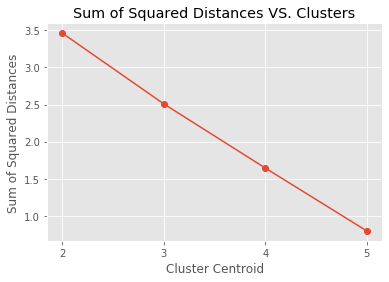

<Figure size 1440x1440 with 0 Axes>

In [131]:
from sklearn.cluster import KMeans #import kmeans which will be used to cluster the data

import matplotlib.pyplot as plt 
plt.style.use('ggplot')

max_number_of_clusters = 5 #clusters can range from 2-max_number_of_clusters
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a 1 should be added.
Ks = range(2, max_number_of_clusters, 1) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k,random_state=30).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance for each k.
        
  #plot the elbow graph      
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

In [137]:
clusters = KMeans(n_clusters=2,random_state=30).fit_predict(tf_idf_norm_kmeans) #from the elbow graph we get the n_clusters
df =FullPaperDataframe.head(6).copy(deep=True)  #create a new df which will hold the papers attribute along with the cluster number

In [138]:
df['clusters'] = clusters
df.head() #display the head

title  \
0  The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3   
1  Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                             
2  Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China                                                               
3  Relationship between Average Daily Temperature and Average Cumulative Daily Rate of Confirmed Cases of COVID-19                                        
4  CHEER: hierarCHical taxonomic classification for viral mEtagEnomic data via deep leaRning                                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      abstract  \
0  [{'text': 'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAPE and mutation experiments confirmed the importance of the previously predicted PK 37 structures for their function. Deletion experiments showed that although PKs are not essential 38', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'for replication, they provide genomes with a competitive advantage. However, although 39 replicons and full-length genomes lacking all PKs were replication competent, no

In [ ]:
# taged_abs=[]
# nouns=[]
# # tagging the clean data
# for val in clean_abs:
#     taged_abs.append(pos_tag(val.split()))
# # extracting the nouns
# for i in range(len(taged_abs)):
#     doc=[]
#     for j in range(len(taged_abs[i])):
#         if(taged_abs[i][j][1]=='NN' or taged_abs[i][j][1]=='NNS'):
#             doc.append(taged_abs[i][j][0])
#     nouns.append(doc)
        
# print(nouns)



Above we dcided to calculate the tf-idf so that we can represent every word that is present in the abstract quatitavily. By doing so we can further use the results in order model the topic according to the abstract that we just quatified.Furthermore we will use (Non-negative Matrix Factorization) NMF in order to come up with topic's that carry most weight in the abstract. To accomplish this we are going to filter all the nouns that are avaliable in the abstract and use them to represent the different topis that are avaliable.